In [11]:
import pickle
import os
import torch
from torchvision import datasets
from torchvision import transforms
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import precision_recall_fscore_support

In [12]:
#loaded as numpy 

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data(): #Load data. use for raw data and PCA
    cifar_path="data/cifar-10-batches-py"
    test_path=os.path.join(cifar_path,'test_batch')
    train_data=np.zeros((10000,3072),dtype=np.uint8)
    train_label=np.zeros((10000,1),dtype=np.uint8)
    

    #load train set
    for i in range(1,6):
        path=cifar_path+"/data_batch_"+str(i)
        img_dict=unpickle(path)
        label=np.asarray(img_dict[b'labels']).reshape(-1,1)
        if i==1 :
            train_data=np.asarray(img_dict[b'data'],dtype=np.uint8)
            train_label=np.asarray(label,dtype=np.uint8)
        else:
            train_data=np.concatenate((train_data,img_dict[b'data']),axis=0)
            train_label=np.concatenate((train_label,label),axis=0)

    train_label=train_label.reshape(-1)

    #load test set
    img_test=unpickle(test_path);
    test_data=img_test[b'data']
    test_label=np.asarray(img_test[b'labels'])

    train_data=train_data/255
    test_data=test_data/255
    
    return train_data,train_label,test_data,test_label


# find optimal K

The validation set is only used to determine the hyperparameters, which are not needed to be used in the coordinate transformation later, so only the training set is divided in the original data part, because the training batches are stitched sequentially, and the data of the last batch is directly classified as the validation set. (Because the class distribution of each batch in the dataset is consistent, no additional processing is required)


In [13]:
train_data,train_labels,test_data,test_labels=load_data()

new_train_data=train_data[:40000]
new_train_labels=train_labels[:40000]
valid_data=train_data[40000:]
valid_labels=train_labels[40000:]

In [9]:
#optimal K
K_list=list(range(5,27,2))
accuray_list=[]

for i in K_list:
    neigh = KNeighborsClassifier(i)
    neigh.fit(new_train_data,new_train_labels)
    res = neigh.predict(valid_data)
    accuracy = accuracy_score(valid_labels,res)
    accuray_list.append(accuracy)



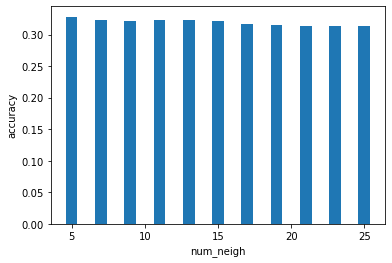

In [10]:
plt.bar(K_list,accuray_list,width=0.8)
plt.xlabel('num_neigh')
plt.ylabel('accuracy')
plt.show()

From the above figure, for the cifar10 dataset, the classification accuracy is less affected by the K value, and we take the highest test accuracy corresponding to 5, which is also the default value of KNN.

The function of the validation set ends, and in the future, all of them are only divided into training set and test set.

In [4]:
#Raw data accuracy and f1score
train_data,train_labels,test_data,test_labels=load_data()
neigh = KNeighborsClassifier(5)
neigh.fit(train_data,train_labels)
res = neigh.predict(test_data)
accuracy = accuracy_score(test_labels,res)
print("the global accuracy is",accuracy)
f1_macro = f1_score(test_labels,res,average='macro')
print("the macro f1-score is",f1_macro)

the global accuracy is 0.3398
the macro f1-score is 0.3260170986061005


In [6]:
#each class accuracy
p_class, r_class, f1_class, _ = precision_recall_fscore_support(test_labels,res,labels=[0,1,2,3,4,5,6,7,8,9])
for i in range(10):
    print("the recall ratio of class %d is %f,the precision ratio is %f" %(i,r_class[i],p_class[i]))

the recall ratio of class 0 is 0.537000,the precision ratio is 0.383024
the recall ratio of class 1 is 0.205000,the precision ratio is 0.646688
the recall ratio of class 2 is 0.452000,the precision ratio is 0.225324
the recall ratio of class 3 is 0.217000,the precision ratio is 0.294038
the recall ratio of class 4 is 0.514000,the precision ratio is 0.244065
the recall ratio of class 5 is 0.220000,the precision ratio is 0.392157
the recall ratio of class 6 is 0.248000,the precision ratio is 0.346369
the recall ratio of class 7 is 0.210000,the precision ratio is 0.677419
the recall ratio of class 8 is 0.655000,the precision ratio is 0.398661
the recall ratio of class 9 is 0.140000,the precision ratio is 0.696517


### PCA

In [14]:
train_data,train_labels,test_data,test_labels=load_data()
total_data=np.concatenate((train_data,test_data),axis=0)


In [13]:
comp_list=[0.95,0.97,0.99] 



#The value here is the error between the data 
                           #I recovered after pca processing and the original data, 
                           #0.99 means that 99% of the information can be retained
accuracy_list=[]
f1_list=[]
for i in comp_list:
    pca=PCA(n_components=i)
    data_trans=pca.fit_transform(total_data)
    trans_train=data_trans[:50000]
    trans_test=data_trans[50000:]
    neigh = KNeighborsClassifier(5)
    neigh.fit(trans_train,train_labels)
    res = neigh.predict(trans_test)
    accuracy = accuracy_score(test_labels,res)
    print('for variance percentage, the compnent number is '+str(trans_train.shape[1]))
    print("the global accuracy is",accuracy)
    f1_macro = f1_score(test_labels,res,average='macro')
    print("the macro f1-score is",f1_macro)
    accuracy_list.append(accuracy)
    f1_list.append(f1_macro)

for variance percentage, the compnent number is217
the global accuracy is 0.3621
the macro f1-score is 0.35404655740728136
for variance percentage, the compnent number is335
the global accuracy is 0.3529
the macro f1-score is 0.3416606844999087
for variance percentage, the compnent number is660
the global accuracy is 0.3438
the macro f1-score is 0.33120442727063654


It shows that for the cifar0 dataset, for the KNN classification method, PCA can reduce redundant information and help to improve the classification accuracy

In [16]:

pca=PCA(0.95)
data_trans=pca.fit_transform(total_data)
trans_train=data_trans[:50000]
trans_test=data_trans[50000:]
neigh = KNeighborsClassifier(5)
neigh.fit(trans_train,train_labels)
res = neigh.predict(trans_test)

p_class, r_class, f1_class, _ = precision_recall_fscore_support(test_labels,res,labels=[0,1,2,3,4,5,6,7,8,9])
for i in range(10):
    print("the recall ratio of class %d is %f,the precision ratio is %f" %(i,r_class[i],p_class[i]))

the recall ratio of class 0 is 0.565000,the precision ratio is 0.387517
the recall ratio of class 1 is 0.257000,the precision ratio is 0.645729
the recall ratio of class 2 is 0.454000,the precision ratio is 0.235599
the recall ratio of class 3 is 0.205000,the precision ratio is 0.305514
the recall ratio of class 4 is 0.497000,the precision ratio is 0.253571
the recall ratio of class 5 is 0.223000,the precision ratio is 0.429672
the recall ratio of class 6 is 0.340000,the precision ratio is 0.348718
the recall ratio of class 7 is 0.244000,the precision ratio is 0.668493
the recall ratio of class 8 is 0.645000,the precision ratio is 0.437882
the recall ratio of class 9 is 0.191000,the precision ratio is 0.751969


### kPCA

implement each Batch
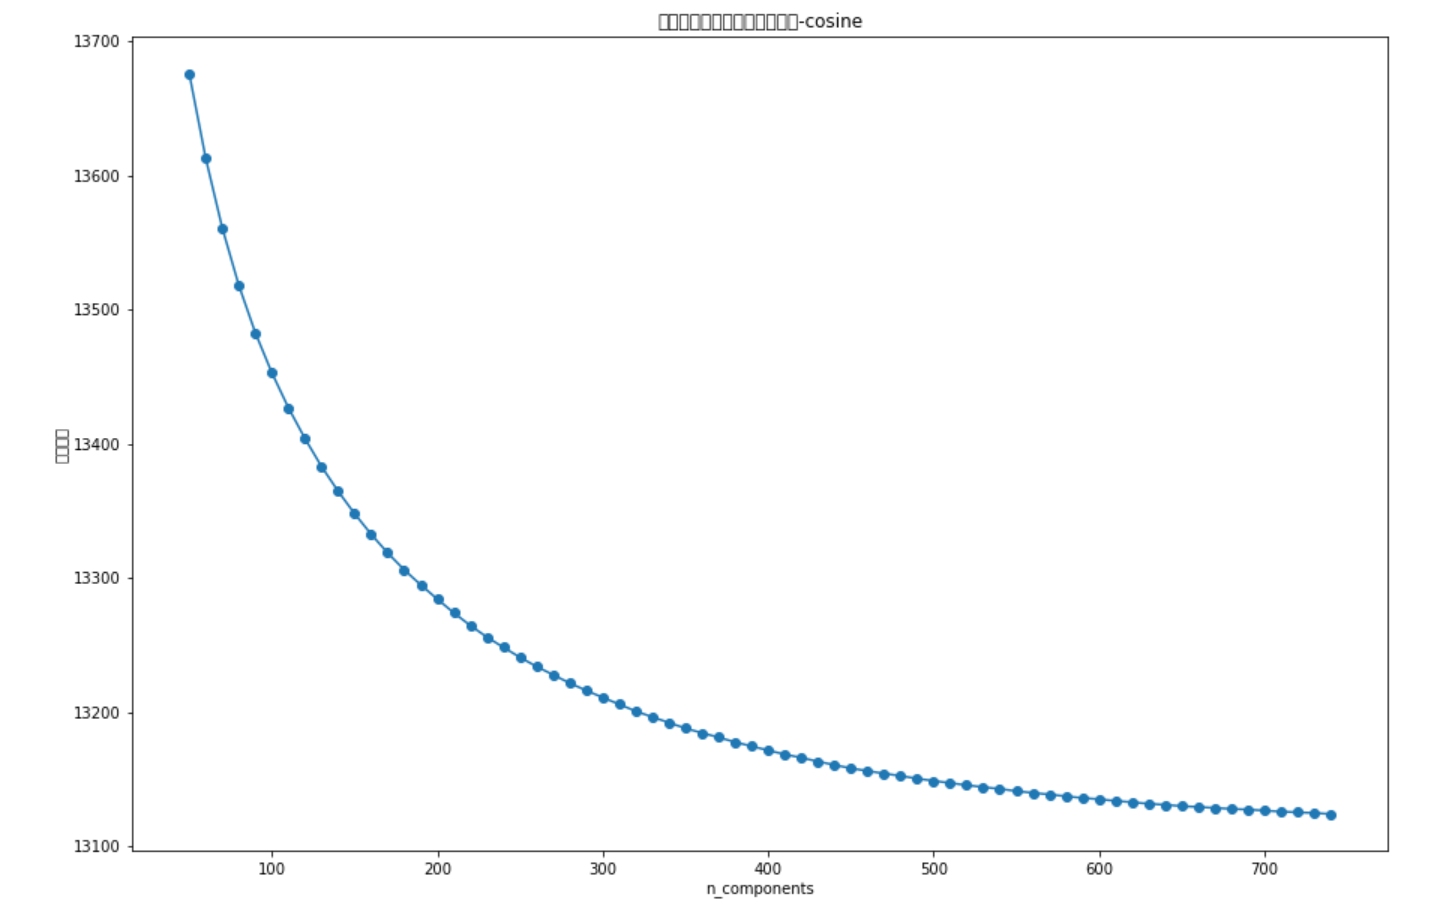

In [ ]:

# mse_cosine_n=list()
# for i in range(50,750,10):
#     kpca = KernelPCA(n_components=i, kernel="cosine", fit_inverse_transform=True)
#     X_reduced = kpca.fit_transform(test_data)
#     X_back = kpca.inverse_transform(X_reduced)
#     mse_cosine_n.append(mean_squared_error(X_back, test_data))

# fs=10   
# fig=plt.figure(figsize=(15,10))
# ax=fig.add_subplot(1,1,1)
# ax.plot(range(50,750,10),mse_cosine_n,marker='o')   
# ax.set_title("Reconstruction error-cosine")
# ax.set_xlabel("n_components")
# ax.set_ylabel("Reconstruction error")

Then the data are subjected to kPCA dimensionality reduction with three cases of dimensionality reduction 215,500,800, limited by memory, and kpca processing is performed for each batch of the training data.

In [24]:
#加载为numpy格式方便后续处理
cifar_path="data/cifar-10-batches-py"
path=os.path.join(cifar_path,'test_batch')
train_data=np.zeros((10000,3072),dtype=np.uint8)
train_label=np.zeros((10000,1),dtype=np.uint8)
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [25]:
#load batch
accuracy_list=[]
f1_list=[]
dimension_list=[216,500,800]#three dimensions
for j in dimension_list:
    train_data=np.zeros((10000,3072),dtype=np.uint8)
    train_label=np.zeros((10000,1),dtype=np.uint8)
    for i in range(1,6):
        path=cifar_path+"/data_batch_"+str(i)
        img_dict=unpickle(path)
        label=np.asarray(img_dict[b'labels']).reshape(-1,1)
        data=img_dict[b'data']/255
        kpca = KernelPCA(n_components=j,kernel="cosine")
        data_trans=kpca.fit_transform(data)
        if i==1:
            train_data=np.asarray(data_trans)
            train_label=np.asarray(label)
        else:
            train_data=np.concatenate((train_data,data_trans),axis=0)
            train_label=np.concatenate((train_label,label),axis=0)

    train_label=train_label.reshape(-1)      

    #test
    img_test=unpickle(path);
    test_data=img_test[b'data']
    test_data=test_data/255
    test_label=np.asarray(img_test[b'labels'])
    kpca = KernelPCA(n_components=j,kernel="cosine")
    test_data=kpca.fit_transform(test_data)


    neigh = KNeighborsClassifier(5)
    neigh.fit(train_data,train_label)
    res = neigh.predict(test_data)
    accuracy = accuracy_score(test_label,res)
    print('for compnent number '+str(j)+' :')
    print("the global accuracy is",accuracy)
    f1_macro = f1_score(test_label,res,average='macro')
    print("the macro f1-score is",f1_macro)
    accuracy_list.append(accuracy)
    f1_list.append(f1_macro)

for compnent number 216 :
the global accuracy is 0.4724
the macro f1-score is 0.46368927616736044
for compnent number 500 :
the global accuracy is 0.4534
the macro f1-score is 0.44255181278502925
for compnent number 800 :
the global accuracy is 0.4474
the macro f1-score is 0.4355188635532084


In [26]:
p_class, r_class, f1_class, _ = precision_recall_fscore_support(test_labels,res,labels=[0,1,2,3,4,5,6,7,8,9])
for i in range(10):
    print("the recall ratio of class %d is %f,the precision ratio is %f" %(i,r_class[i],p_class[i]))

the recall ratio of class 0 is 0.195000,the precision ratio is 0.107497
the recall ratio of class 1 is 0.039000,the precision ratio is 0.088435
the recall ratio of class 2 is 0.142000,the precision ratio is 0.097527
the recall ratio of class 3 is 0.095000,the precision ratio is 0.091965
the recall ratio of class 4 is 0.145000,the precision ratio is 0.108777
the recall ratio of class 5 is 0.088000,the precision ratio is 0.101617
the recall ratio of class 6 is 0.053000,the precision ratio is 0.100000
the recall ratio of class 7 is 0.026000,the precision ratio is 0.078788
the recall ratio of class 8 is 0.210000,the precision ratio is 0.109833
the recall ratio of class 9 is 0.025000,the precision ratio is 0.087719


# LE

In [28]:
#numpy
cifar_path="data/cifar-10-batches-py"
path=os.path.join(cifar_path,'test_batch')
train_data=np.zeros((10000,3072),dtype=np.uint8)
train_label=np.zeros((10000,1),dtype=np.uint8)
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#batch
for i in range(1,6):
    path=cifar_path+"/data_batch_"+str(i)
    img_dict=unpickle(path)
    label=np.asarray(img_dict[b'labels']).reshape(-1,1)
    data=img_dict[b'data']/255
    LE=SpectralEmbedding(216)
    data_trans=LE.fit_transform(data)
    if i==1:
        train_data=np.asarray(data_trans)
        train_label=np.asarray(label)
    else:
        train_data=np.concatenate((train_data,data_trans),axis=0)
        train_label=np.concatenate((train_label,label),axis=0)

train_label=train_label.reshape(-1)      

#test
img_test=unpickle(path);
test_data=img_test[b'data']
test_data=test_data/255
test_label=np.asarray(img_test[b'labels'])
LE=SpectralEmbedding(216)
test_data=LE.fit_transform(test_data)

In [29]:
neigh = KNeighborsClassifier(5)
neigh.fit(train_data,train_label)
res = neigh.predict(test_data)
accuracy = accuracy_score(test_label,res)
print("the global accuracy is",accuracy)
f1_macro = f1_score(test_label,res,average='macro')
print("the macro f1-score is",f1_macro)

the global accuracy is 0.5258
the macro f1-score is 0.5250710653275553


In [30]:
p_class, r_class, f1_class, _ = precision_recall_fscore_support(test_label,res,labels=[0,1,2,3,4,5,6,7,8,9])
for i in range(10):
    print("the recall ratio of class %d is %f,the precision ratio is %f" %(i,r_class[i],p_class[i]))

the recall ratio of class 0 is 0.728797,the precision ratio is 0.431659
the recall ratio of class 1 is 0.556213,the precision ratio is 0.640909
the recall ratio of class 2 is 0.577731,the precision ratio is 0.403818
the recall ratio of class 3 is 0.431102,the precision ratio is 0.566624
the recall ratio of class 4 is 0.551655,the precision ratio is 0.444265
the recall ratio of class 5 is 0.423415,the precision ratio is 0.617354
the recall ratio of class 6 is 0.525510,the precision ratio is 0.492352
the recall ratio of class 7 is 0.422723,the precision ratio is 0.697635
the recall ratio of class 8 is 0.658026,the precision ratio is 0.562660
the recall ratio of class 9 is 0.386497,the precision ratio is 0.758157


In [31]:
#加载为numpy格式方便后续处理
cifar_path="data/cifar-10-batches-py"
path=os.path.join(cifar_path,'test_batch')
train_data=np.zeros((10000,3072),dtype=np.uint8)
train_label=np.zeros((10000,1),dtype=np.uint8)
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#加载训练集batch并处理
accuracy_list=[]
f1_list=[]
dimension_list=[216,618,800]#这里只用这三个维度，你自己有需要自己加
for j in dimension_list:
    for i in range(1,6):
        path=cifar_path+"/data_batch_"+str(i)
        img_dict=unpickle(path)
        label=np.asarray(img_dict[b'labels']).reshape(-1,1)
        data=img_dict[b'data']/255
        LE=SpectralEmbedding(j)
        data_trans=LE.fit_transform(data)
        if i==1:
            train_data=np.asarray(data_trans)
            train_label=np.asarray(label)
        else:
            train_data=np.concatenate((train_data,data_trans),axis=0)
            train_label=np.concatenate((train_label,label),axis=0)

    train_label=train_label.reshape(-1)      

#加载测试集
    img_test=unpickle(path);
    test_data=img_test[b'data']
    test_data=test_data/255
    test_label=np.asarray(img_test[b'labels'])
    
    LE=SpectralEmbedding(j)
    test_data=LE.fit_transform(test_data)
    neigh = KNeighborsClassifier(5)
    neigh.fit(train_data,train_label)
    res = neigh.predict(test_data)
    accuracy = accuracy_score(test_labels,res)
    print("the global accuracy is",accuracy)
    f1_macro = f1_score(test_label,res,average='macro')
    print("the macro f1-score is",f1_macro)
    accuracy_list.append(accuracy)
    f1_list.append(f1_macro)
    
    

the global accuracy is 0.1022
the macro f1-score is 0.5250710653275553
the global accuracy is 0.0922
the macro f1-score is 0.3199798211802446


KeyboardInterrupt: 